# 2. Quick Start
In this notebook, we learn how to create a full deep learning project in PyTorch. Broadly speaking, a project consists of four components:
 * Defining the task
 * Preparing the dataset
 * Designing the network
 * Train, validation and testing routines
 
In this toy example we want a network to classify geometrical shapes in images, i.e., whether an image contain a circle, square, triangle, etc.

## 0. Packages

Let's start with all the necessary packages to implement this tutorial.

 * [numpy](https://numpy.org/) is the main package for scientific computing with Python. It's often imported with the `np` shortcut.
 * [matplotlib](https://matplotlib.org/) is a library to plot graphs in Python.
 * [torch](https://pytorch.org/docs/stable/index.html) is a deep learning framework that allows us to define networks, handle datasets, optimise a loss function, etc.
 * [cv2](https://docs.opencv.org/4.x/index.html) is a leading computer vision library.

In [1]:
# importing the necessary packages/libraries
import numpy as np
from matplotlib import pyplot as plt
import random

import torch
import torch.nn as nn
import torchvision

import cv2

Choosing CPU or GPU based on the availability of the hardware.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 1. Dataset 

The first step is to get the data ready. In this tutorial, we create our dataset on the fly, i.e., we generate images containing simple geometrical shapes. Our dataset contains three types of shapes: 
 * circle
 * ellipse
 * rectangle.

In [3]:
labels_map = {
    0: "circle",
    1: "ellipse",
    2: "rectangle"
}

### dataset-utility functions.
First we create all the ulitiy functions to generate a set of images.
 * `create_random_background` simply creates a square matrix of size `(s, s, 3)`, the third dimension corresponds to RGB channels.
 * `create_random_shape`uses `cv2` functions to draw geometrical shapes on top of an image.

In [4]:
def create_random_background(img_size, p=0.5):
    """This functions creates a background image."""
    # if the random value larger than 0.5, the background will be random noise, otherwise, random uniform
    if np.random.rand() > p:
        return np.random.randint(0, 256, (img_size, img_size, 3), dtype='uint8')
    else:
        return np.zeros((img_size, img_size, 3), dtype='uint8') + np.random.randint(0, 256, dtype='uint8')

def create_random_shape(img, filled):
    """This functions generates geometrical shapes on top of a background image."""
    # choosing a colour for the shape, there is a slim chance of being identical to the background,
    # we can consider this the noise in our dataset!
    colour = [random.randint(0, 255) for _ in range(3)]
    thickness = np.random.randint(2, 7)
    point1 = np.random.randint(img.shape[0] // 4, 3 * (img.shape[0] // 4), 2)
    
    # drawing a random geomterical shape
    shape_ind = np.random.randint(0, len(labels_map))
    # when the tickness is negative, the shape is drawn filled
    thickness *= -1 if filled else np.random.choice([-1, 1])
    
    if shape_ind == 0: # circle
        radius = np.random.randint(10, img.shape[0] // 4)
        img = cv2.circle(img, point1, radius, color=colour, thickness=thickness)
    elif shape_ind == 1: # ellipse
        axes = [
            np.random.randint(10, 20),
            np.random.randint(30, img.shape[0] // 4)
        ]
        angle = np.random.randint(0, 360)
        img = cv2.ellipse(img, point1, axes, angle, 0, 360, color=colour, thickness=thickness)
    else: # rectangle
        point2 = np.random.randint(0, img.shape[0], 2)
        img = cv2.rectangle(img, point1, point2, color=colour, thickness=thickness)
    return img, shape_ind

### train/test sets

Usually, a dataset contains three sets:

*   **Training**: the set in which the knowledge of a network is learnt from.
*   **Validation**: this set is usually used for hyper parameter tunning.
*   **Testing**: evaluating the model based on various metrics.

A rule of thumb to split your data: 70% training, 15% validation, 15% testing.

![train/validation/test](https://blog.kakaocdn.net/dn/UenrJ/btrk6fXBfbJ/4iGSlrWj4mVJxzmup2KVr1/img.png)

In our example, we create two sets of images. One for training another for testing. We skipped the validation, because we're not doing any hyper parameter tunning.

`make_image_set` is a utility functoin to create a dataset of images containing geometrical shapes.

**Note**: this functoins cannot be scaled to large datasets as it loads all images into a large list. For instance, if we want to have one million images, we run out of memory.

**Exercise**: this is one part of assignment 2, how to change this notebook to handle an arbitrary large dataset.

In [5]:
def make_image_set(num_imgs, img_size, bg_p, filled):
    """Creating the set of images."""
    imgs = []
    gts = []
    for i in range(num_imgs):
        # creating the background, either a random uniform colour, or random noise
        img = create_random_background(img_size, bg_p)
        # drawing a random shape
        img, gt = create_random_shape(img, filled)
        imgs.append(img)
        gts.append(gt)
    return imgs, gts

In this example we create a trarin set of 1000 images and a test set of 100 images.

In [6]:
# definying the parametrs of the dataset
img_size = 128
filled = True # whether the geometrical shapes are only the contour or filled
bg_uniform_vs_noise = 1 # the probability of the backgroud being a uniform colour or a noisy image

number_trains = 1000
number_test = number_trains // 10

train_imgs, train_gts = make_image_set(number_trains, img_size, bg_p=bg_uniform_vs_noise, filled=filled)
test_imgs, test_gts = make_image_set(number_test, img_size, bg_p=bg_uniform_vs_noise, filled=filled)

### dataset visualisation

Let's have a loot at the generated images. We use `plt` from `matplotlib` libraryto create a figure and a grid of 10x10 subplots. On top of each image we write its corresponding ground-truth.

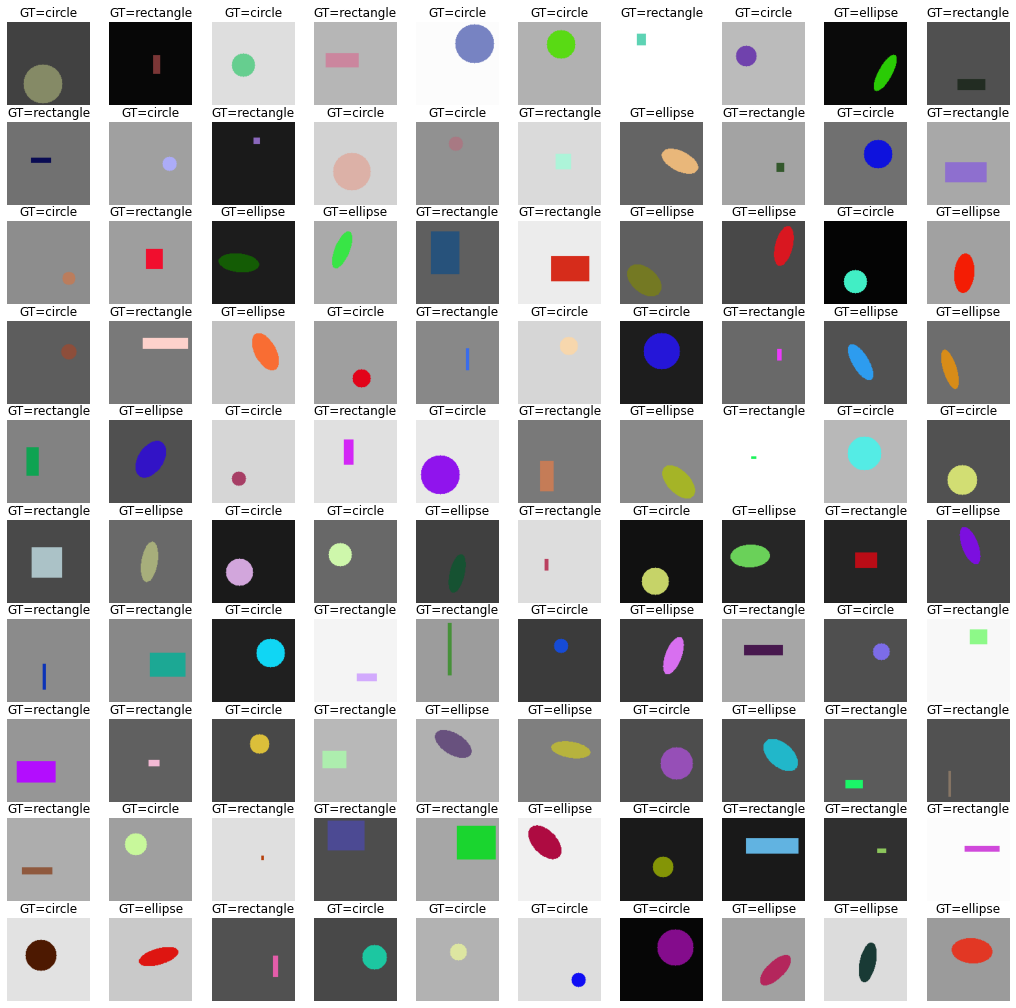

In [7]:
# plot 100 of the images
fig = plt.figure(figsize=(18, 18))
for i in range(100):
    ax = fig.add_subplot(10, 10, i+1)
    ax.imshow(train_imgs[i])
    ax.axis('off')
    ax.set_title('GT=%s' % labels_map[train_gts[i]])

### PyTorch Data Pipeline

Now, that we have created our dataset, we have to create PyTorch dataloaders.

In this example, we're creating a simple dataloader class ```ShapeDataset``` that inherits the ```torch.utils.data.Dataset``` class. It has to implement two functioons:
 * ```__len__``` (return the number of samples in the dataset) 
 * ```__getitem__``` that yield the approperiate data. 

Usually, the datasets used in deep-learning projects are huge (e.g., ImageNet contains 1.5 million images). Therefore, we cannot load all images in the memory and we read each image dynamically in the ```__getitem__``` function. 

One can create any sort of custom datasets with the same structure as our toy example. The initialisatoin function (`__init__`) recevies all the necessary parameters to create a dataset. Usually the passes variables are stored as class variables to use later on in the `__getitem__` function. Sometimes the `__init__` function has to prepare data paths, e.g., to read the name of all image files in folder (**important** not the images themseveles that are heavy for the memory but ony their paths to load later).

The argument `transform` is typically part of any dataset. `transform` contains a predefined set of functoins that are sequentially exectures on an image. Typical examples of such functions include:
 * Conversion to torch tensor
 * Normalising the input image
 * Data augmentions such as random cropping or flipping of an image.
 * etc.

In [8]:
# PyTorch dataset
class ShapeDataset(torch.utils.data.Dataset):

    def __init__(self, imgs, gts, transform=None):
        self.imgs = imgs
        self.gts = gts
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        # idx is the sample number
        img = self.imgs[idx]
        gt = self.gts[idx] # the ground-truth for the image, i.e. shape-ID

        # 
        if self.transform:
            img = self.transform(img)

        return img, gt

#### transform functions

In this toy example we define only two necessary transformation functions:
 * `ToTensor` The data must be converted to torch tensors by calling ```ToTensor``` function.
 * `Ǹormalize` Deep networks are trained betetr and faster when the data is centered at 0. For this reason, we apply the ```Normalize```functions with specific ```mean``` and ```std```.
 
In our exmple we have only used the functoins defined by the `torchvision.transforms` package, but one can (and will need to) implement its own set of transform functions as well.
 
Note that `torchvision.transforms.Compose` receives a list of functoins that will be exceuted sequentially. 

In [9]:
# make the pytorch datasets
mean = 0.5
std = 0.25
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean, std),
])

#### Dataloaders

The dataloaders (`torch.utils.data.DataLoader`) allow us to handle large datasets in several batches.

The ```DataLoader``` class receives a numebr of parameters, such as:
 * ```batch_size``` how many samples (images) to process at every batch. Batches are useful to speed up the processing pipeline as they are computed in one go in GPU. Batches are also important to compute the Stochastic gradient descent.
 * ```num_workers``` defines the numebr of CPU threads to preprocess the data before inputing it to GPU. Typically for large batches, we need more CPU threads to speed up the preprocessing. In practice, one has to find the balance between the computational efficiency of its GPU and CPU.

**Note**: these parameters don't have to be identical in train/test scenarios. For example, 
 * We often can afford larger ```batch_size``` in test time because gradients don't need to be computed. 
 * We also don't want to ```shuffle``` the data at test time, contraray to this, we often want to ```shuffle``` the training samples.



In [10]:
train_dataset = ShapeDataset(train_imgs, train_gts, transform)

batch_size = 8
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    num_workers=2, pin_memory=True, sampler=None
)

val_dataset = ShapeDataset(test_imgs, test_gts, transform)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False,
    num_workers=2, pin_memory=True, sampler=None
)

## 2. Model

Now that we have sucessfully generated our images and created approperiate PyTorch dataloaders, we can define our network.

### architecture

The task we're modelling is relativeley simple and we don't need a complex network. Our model inherits the ```torch.nn.Module``` class and has to at least implement one function ```forward```.

`forward` function is calles when we input a network with data. In our example, the network receives only one input (a batch of images), but the `forward` functoin can receive multiple arguments which is necessary in several usecases, e.g., 
 * pairs of images to compare whether they are similar,
 * triple images to find the odd-one-out.

In the ```__init__``` function, we define the architecure. In this case, the feature processing part consists of three convolutional blocks followed by batch normalisation, ReLU rectification and max pooling. The classifier is a linear function.

In [11]:
## creating model
class SimpleNet(nn.Module):
    def __init__(self, num_classes: int) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1), # in=3, out=16
            nn.BatchNorm2d(16), # it must be the same as out of prvious layer
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), # in=16 (it must be the same as out of previous layer)
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1)) # global average across the entire spatial resolution
        self.classifier = nn.Linear(1*1*64, num_classes) # input=64 (must be the same size as out of previous layer after vectorisation)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # the input x is processed with the network
        x = self.features(x)
        x = self.avgpool(x)
        # we vectorise the x, classifier expect a 1D array.
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

### network

Next we make an instance of our previously defined architecture.
We move the model to GPU and print the model.

In [12]:
## makign the model
model = SimpleNet(num_classes=3)
model = model.to(device)
print(model)

SimpleNet(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
  (classifier): Linear(in_features=64, out_features=3, bias=True)
)


## 3. Train/test routines

We have our dataset and model ready. It's time to start the training and validate what the network learns.

### optimizer

First, we define what parameters we want to optimise.
**Note**: we neither have to optimise all the parameters, nor optimise all with the same ```learning_rate```.

For our purpose, the most important parameter is the ```learning_rate```.
![learning-rate](https://www.jeremyjordan.me/content/images/2018/02/Screen-Shot-2018-02-24-at-11.47.09-AM.png)

In our example we use the `SGD` algoithm to optimise all parameters of the network. 

In [13]:
# optimizer and criterion
params_to_optimize = [{'params': [p for p in model.parameters()]}]
momentum = 0.9
learning_rate = 0.01
weight_decay = 1e-4
optimizer = torch.optim.SGD(
    params_to_optimize, lr=learning_rate,
    momentum=momentum, weight_decay=weight_decay
)

### loss-functoin

Loss functoins defines how good is the network output with respect to the ground-truth. In our toy example, the ground-truth is **semi-supervised** (i.e., we have defined it but indirectly by means of the quations for geometrical shapes; we didn't have to labarously label each image ourself).

Our ground-truth is a set of categories (i.e., three classes of geometrical shapes). A suitable loss function for this scenario is the categorical cross entropy. We create `nn.CrossEntropyLoss`and move it to device (CPU or CUDA).

In [14]:
criterion = nn.CrossEntropyLoss().to(device)

### training utility functions

We define a function to compute the `accuracy` of the output with respect to ground truth.

In [15]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

Next, we define a utility function `epoch_loop` that can be called at each epoch (epoch informally means processing all samples in the dataset one time).

Typically, a large portion of code is identical for training and testing, therefore it's recommendable to have one single function for both. Exclusive code for training or testing can be easily separated by an `if` statement. In our example, only at training do the following three steps:
 1. computing the gradient `optimizer.zero_grad`
 2. backpropagating the loss `loss.backward`
 3. Optimising the weights `optimizer.step`

<font color='red'>**Important**</font>: when evaluating a model ```eval()``` function must be called, otherwise the parameters of the model will be updated!

<font color='red'>**Important**</font>: ```torch.set_grad_enabled``` must be set to ```True``` during training and ```False``` during testing.

In [16]:
def epoch_loop(model, db_loader, criterion, optimiser):
    # usually the code for train/test has a large overlap.
    is_train = False if optimiser is None else True

    # model should be in train/eval model accordingly
    model.train() if is_train else model.eval()
    
    accuracies = []
    losses = []
    with torch.set_grad_enabled(is_train):
        for batch_ind, (img, target) in enumerate(db_loader):
            # moving the image and GT to device
            img = img.to(device)
            target = target.to(device)
            output = model(img)
            
            # computing the loss function
            loss = criterion(output, target)
            losses.extend([loss.item() for i in range(img.size(0))])
            # computing the accuracy
            acc = accuracy(output, target)[0].cpu().numpy()
            accuracies.extend([acc[0] for i in range(img.size(0))])
            
            if is_train:
                # compute gradient and do SGD step
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
    return accuracies, losses

## 4. Starting the programme

We have everything (dataset, model, loss/optimiser), so we can start the training/testing loop.

In this toy example, we perform 10 epochs (i.e., we process each sample in the dataset 10 times).

In [17]:
# doing epoch
epochs = 10
initial_epoch = 0
train_logs = {'acc': [], 'loss': []}
val_logs = {'acc': [], 'loss': []}
for epoch in range(initial_epoch, epochs):
    train_log = epoch_loop(model, train_loader, criterion, optimizer)
    
    val_log = epoch_loop(model, val_loader, criterion, None)
    
    print('[%.2d] Train     loss=%.4f     acc=%0.2f    [%.2d] Test     loss=%.4f     acc=%0.2f' % 
          (
              epoch, np.mean(train_log[1]), np.mean(train_log[0]),
              epoch, np.mean(val_log[1]), np.mean(val_log[0])
          ))
    train_logs['acc'].append(np.mean(train_log[0]))
    train_logs['loss'].append(np.mean(train_log[1]))
    val_logs['acc'].append(np.mean(val_log[0]))
    val_logs['loss'].append(np.mean(val_log[1]))

[00] Train     loss=1.1494     acc=37.30    [00] Test     loss=1.1510     acc=37.00
[01] Train     loss=1.1292     acc=38.70    [01] Test     loss=1.0655     acc=38.00
[02] Train     loss=1.1050     acc=41.70    [02] Test     loss=1.1118     acc=44.00
[03] Train     loss=1.0698     acc=44.00    [03] Test     loss=1.1082     acc=46.00
[04] Train     loss=0.9908     acc=51.20    [04] Test     loss=1.3766     acc=35.00
[05] Train     loss=0.9078     acc=53.80    [05] Test     loss=1.0856     acc=42.00
[06] Train     loss=0.8200     acc=58.50    [06] Test     loss=0.9332     acc=57.00
[07] Train     loss=0.6947     acc=64.80    [07] Test     loss=1.1290     acc=49.00
[08] Train     loss=0.7689     acc=59.80    [08] Test     loss=0.8735     acc=52.00
[09] Train     loss=0.6892     acc=62.50    [09] Test     loss=0.7471     acc=54.00


## 5. Results

Let's look at the accuracies and losses by plotting them as a function of epoch numbers.
These figures can help us to evaluate whether the hyperparameters are good.

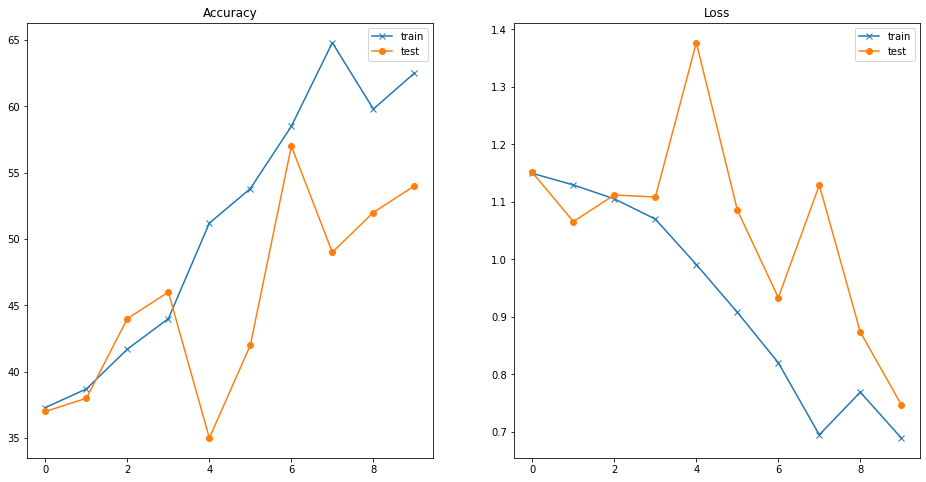

In [18]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 2, 1)
ax.plot(train_logs['acc'], '-x', label='train')
ax.plot(val_logs['acc'], '-o', label='test')
ax.set_title('Accuracy')
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.plot(train_logs['loss'], '-x', label='train')
ax.plot(val_logs['loss'], '-o', label='test')
ax.set_title('Loss')
ax.legend()